In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'D:\ljy\lasif data\satellite_image'

In [3]:
data_root = pathlib.Path(data_dir)

In [4]:
data_root

WindowsPath('D:/ljy/lasif data/satellite_image')

In [5]:
for item in data_root.iterdir():
    print(item)

D:\ljy\lasif data\satellite_image\airplane
D:\ljy\lasif data\satellite_image\lake


In [6]:
all_image_path = list(data_root.glob('*/*'))

In [7]:
all_image_path[:3]

[WindowsPath('D:/ljy/lasif data/satellite_image/airplane/airplane_001.jpg'),
 WindowsPath('D:/ljy/lasif data/satellite_image/airplane/airplane_002.jpg'),
 WindowsPath('D:/ljy/lasif data/satellite_image/airplane/airplane_003.jpg')]

In [8]:
all_image_path = [str(i) for i in all_image_path]

In [9]:
all_image_path[:3]

['D:\\ljy\\lasif data\\satellite_image\\airplane\\airplane_001.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\airplane\\airplane_002.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\airplane\\airplane_003.jpg']

In [10]:
random.shuffle(all_image_path)

In [11]:
all_image_path[:3]

['D:\\ljy\\lasif data\\satellite_image\\lake\\lake_644.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\lake\\lake_452.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\lake\\lake_558.jpg']

In [12]:
image_count = len(all_image_path)
image_count

1400

In [13]:
label_name = sorted(item.name for item in data_root.glob('*/'))
label_name

['airplane', 'lake']

In [14]:
label2index = dict((name, index) for index, name in enumerate(label_name))
label2index

{'airplane': 0, 'lake': 1}

In [15]:
index2label = dict((v,k) for k,v in label2index.items())
index2label

{0: 'airplane', 1: 'lake'}

In [16]:
all_image_label = [label2index[pathlib.Path(path).parent.name] for path in all_image_path]

In [17]:
all_image_label[:3]

[1, 1, 1]

In [18]:
all_image_path[:3]

['D:\\ljy\\lasif data\\satellite_image\\lake\\lake_644.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\lake\\lake_452.jpg',
 'D:\\ljy\\lasif data\\satellite_image\\lake\\lake_558.jpg']

In [19]:
import IPython.display as display

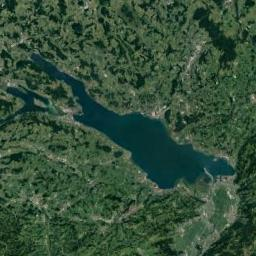

lake
D:\ljy\lasif data\satellite_image\lake\lake_074.jpg


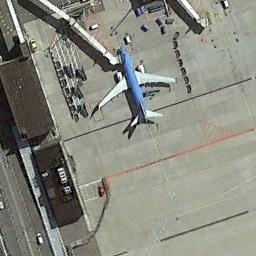

airplane
D:\ljy\lasif data\satellite_image\airplane\airplane_577.jpg


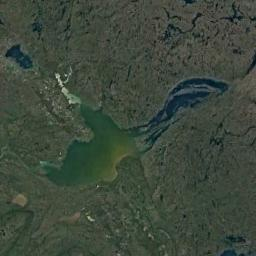

lake
D:\ljy\lasif data\satellite_image\lake\lake_083.jpg


In [20]:
for n in range(3):
    image_index = random.choice(range(len(all_image_path)))
    display.display(display.Image(all_image_path[image_index]))
    print(index2label[all_image_label[image_index]])
    print(all_image_path[image_index])

In [21]:
def load_perprocess_image(img_path):
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    img_tensor = tf.image.resize(img_tensor, [256, 256])
    img = tf.cast(img_tensor, tf.float32) / 255
    return img

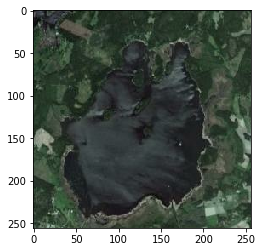

In [22]:
plt.imshow(load_perprocess_image(all_image_path[0]))

In [23]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)

In [24]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_dataset = path_ds.map(load_perprocess_image, num_parallel_calls=AUTOTUNE)
image_dataset

<ParallelMapDataset shapes: (256, 256, 3), types: tf.float32>

In [26]:
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_label, tf.int64))

In [27]:
for label in label_dataset.take(10):
    print(label.numpy())

1
1
1
1
1
0
1
1
0
0


In [28]:
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
dataset

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [29]:
test_count = int(image_count * 0.2)
train_count = image_count - test_count

In [30]:
train_count, test_count

(1120, 280)

In [31]:
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

In [32]:
BATCH_SIZE = 32

In [33]:
train_dataset

<SkipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [34]:
train_data = train_dataset.shuffle(buffer_size=train_count).repeat().batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)
train_data

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [35]:
test_data = test_dataset.batch(BATCH_SIZE)

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [39]:
step_per_epoch = train_count//BATCH_SIZE
validation_step = test_count//BATCH_SIZE

In [40]:
history = model.fit(train_data, epochs=30, 
          steps_per_epoch=step_per_epoch, 
          validation_data=test_data, 
          validation_steps=validation_step)

Train for 35 steps, validate for 8 steps
Epoch 1/30
35/35 [==============================] - 452s 13s/step - loss: 0.6828 - acc: 0.5732 - val_loss: 0.4275 - val_acc: 0.8672
Epoch 2/30
35/35 [==============================] - 410s 12s/step - loss: 0.6614 - acc: 0.5688 - val_loss: 0.6482 - val_acc: 0.5156
Epoch 3/30
35/35 [==============================] - 387s 11s/step - loss: 0.5514 - acc: 0.7268 - val_loss: 0.4217 - val_acc: 0.8711
Epoch 4/30
35/35 [==============================] - 414s 12s/step - loss: 0.7362 - acc: 0.7598 - val_loss: 0.6965 - val_acc: 0.5742
Epoch 5/30
35/35 [==============================] - 422s 12s/step - loss: 0.4474 - acc: 0.8018 - val_loss: 1.8268 - val_acc: 0.9336
Epoch 6/30
35/35 [==============================] - 430s 12s/step - loss: 0.7592 - acc: 0.7929 - val_loss: 0.6483 - val_acc: 0.4844
Epoch 7/30
35/35 [==============================] - 446s 13s/step - loss: 0.9658 - acc: 0.7196 - val_loss: 0.6257 - val_acc: 0.5586
Epoch 8/30
35/35 [=================

In [41]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

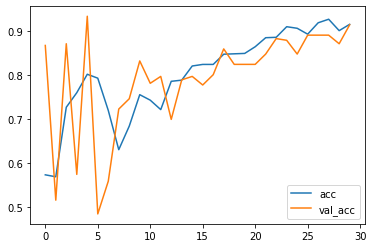

In [43]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

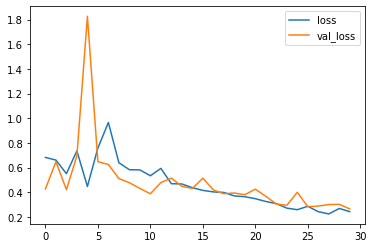

In [44]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()